# Brain Tumor Classification - Model Comparison

This notebook compares the baseline model explored in the previous section with more advanced models including using residual connections, and using Vision Transformers.

## 1. Setup and Imports

In [ ]:
#!/usr/bin/env python
# coding: utf-8
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam
import matplotlib.pyplot as plt
import timm
import time
from torchsummary import summary

In [ ]:
# Topology imports

!pip install gudhi --quiet
!pip install PersistenceImages --quiet
#!pip install persim --quiet
#from persim import PersistenceImager
import gudhi as gd
import PersistenceImages.persistence_images as pimg

In [ ]:
# # import our own modules (if run locally)
# import sys
# sys.path.append('../src')  # Add the src directory to the Python path

from google.colab import drive
drive.mount('/content/drive')

# Use os.path.join to avoid manual path issues
path = os.path.join('gdrive', 'My Drive', 'Erdos', 'brainnet-medical-imaging', 'src')
#os.chdir('/content/drive/My Drive/Deep Learning/BrainNet-Medical Imaging/src')

# Change directory
# os.getcwd()
os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('../src')  # Add the src directory to the Python path

# import data
from config.data import data_setup, data_loader, add_topo_features
from models.vision_transformer import run_training
from utils.prediction import analyze_predictions, train_model
from models.cnn import BrainTumorCNN, BrainTumorCNN_RN, BrainTumorCNN_Topo
from utils.visualization import plot_epoch_times, plot_accuracy_results

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 2. Data Loading and Preprocessing

In [ ]:
# Load data and data_loaders
train_set, test_set, label_conversion_dict = data_setup()
train_loader, test_loader = data_loader(train_set, test_set)

# Extract the class labels from the dictionary keys
class_labels = list(label_conversion_dict.keys())[:4]

/content/drive/MyDrive/Deep Learning/BrainNet-Medical Imaging/Final/src/config/data.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['label'] = df_unique['filepath'].apply(lambda x: x.split('/')[-2])
/content/drive/MyDrive/Deep Learning/BrainNet-Medical Imaging/Final/src/config/data.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['class'] = df_unique['filename'].apply(lambda x: 'train' if x[:2] == 'Tr' else 'test')
100%|██████████| 6726/6726 [00:04<00:00, 1511.76it/s]


Initial number of samples in train set: 5521
Initial number of samples in test set: 1205
Total samples in train set after overriding labels: 5521
Total samples in test set after overriding labels: 1205
Total files in train set: 5521, with target values: [0, 1, 2, 3]
Total files in test set: 1205, with target values: [0, 1, 2, 3]


# 3. Model training

We start with our baseline model

In [ ]:
# Initialize model
model_cnn = BrainTumorCNN().to(device)
print(model_cnn)

BrainTumorCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [ ]:
history = train_model(
    model=model_cnn,
    train_loader=train_loader,
    val_loader=test_loader,
    num_epochs=10
)

# Now you can access the following:
cnn_train_loss_list = history['train_loss_list']
cnn_test_loss_list = history['test_loss_list']
cnn_accuracy_list = history['accuracy_list']
cnn_all_predictions = history['all_predictions']
cnn_all_true_labels = history['all_true_labels']

Epoch 1/10:
Train Loss: 0.7110, Val Loss: 0.5169, Accuracy: 77.43%
Epoch 1 took 18.76 seconds
Epoch 2/10:
Train Loss: 0.4192, Val Loss: 0.3873, Accuracy: 84.32%
Epoch 2 took 19.31 seconds
Epoch 3/10:
Train Loss: 0.3391, Val Loss: 0.3036, Accuracy: 88.46%
Epoch 3 took 19.73 seconds
Epoch 4/10:
Train Loss: 0.2636, Val Loss: 0.2825, Accuracy: 88.38%
Epoch 4 took 23.58 seconds
Epoch 5/10:
Train Loss: 0.2138, Val Loss: 0.2444, Accuracy: 90.87%
Epoch 5 took 18.61 seconds
Epoch 6/10:
Train Loss: 0.1678, Val Loss: 0.3568, Accuracy: 85.06%
Epoch 6 took 17.11 seconds
Epoch 7/10:
Train Loss: 0.1569, Val Loss: 0.2326, Accuracy: 92.28%
Epoch 7 took 16.97 seconds
Epoch 8/10:
Train Loss: 0.1005, Val Loss: 0.1321, Accuracy: 95.02%
Epoch 8 took 17.54 seconds
Epoch 9/10:
Train Loss: 0.0856, Val Loss: 0.3664, Accuracy: 86.89%
Epoch 9 took 20.05 seconds
Epoch 10/10:
Train Loss: 0.0965, Val Loss: 0.2408, Accuracy: 90.95%
Epoch 10 took 16.40 seconds


In [ ]:
# Print the mean of the epoch times
cnn_epoch_times = history['epoch_times']
print(f"CNN mean epoch time: {np.mean(cnn_epoch_times):.2f} seconds")

CNN mean epoch time: 17.19 seconds


In [ ]:
# Analyse and save predictions
analyze_predictions(cnn_all_predictions, cnn_all_true_labels)

# Create a directory called "results" if it doesn't already exist
os.makedirs('results', exist_ok=True)

# Save the lists as numpy arrays for easy reloading
np.save('results/cnn_train_loss_list.npy', np.array(cnn_train_loss_list))
np.save('results/cnn_test_loss_list.npy', np.array(cnn_test_loss_list))
np.save('results/cnn_accuracy_list.npy', np.array(cnn_accuracy_list))
np.save('results/cnn_epoch_times_list.npy', np.array(cnn_epoch_times))

# Save predictions and true labels as pickle files (more efficient for storing lists of lists)
with open('results/cnn_all_predictions.pkl', 'wb') as f:
    pickle.dump(cnn_all_predictions, f)

with open('results/cnn_all_true_labels.pkl', 'wb') as f:
    pickle.dump(cnn_all_true_labels, f)

print("All results have been successfully saved in the 'results/' directory.")



Analyzing predictions for: Model
Epoch 1 Prediction Counts: Counter({np.int64(3): 371, np.int64(0): 300, np.int64(1): 274, np.int64(2): 260})
Epoch 2 Prediction Counts: Counter({np.int64(1): 341, np.int64(2): 321, np.int64(3): 292, np.int64(0): 251})
Epoch 3 Prediction Counts: Counter({np.int64(1): 341, np.int64(2): 331, np.int64(3): 289, np.int64(0): 244})
Epoch 4 Prediction Counts: Counter({np.int64(1): 355, np.int64(2): 329, np.int64(3): 275, np.int64(0): 246})
Epoch 5 Prediction Counts: Counter({np.int64(2): 345, np.int64(3): 319, np.int64(0): 278, np.int64(1): 263})
Epoch 6 Prediction Counts: Counter({np.int64(1): 427, np.int64(2): 318, np.int64(3): 249, np.int64(0): 211})
Epoch 7 Prediction Counts: Counter({np.int64(2): 356, np.int64(3): 302, np.int64(0): 274, np.int64(1): 273})
Epoch 8 Prediction Counts: Counter({np.int64(2): 332, np.int64(0): 306, np.int64(3): 297, np.int64(1): 270})
Epoch 9 Prediction Counts: Counter({np.int64(2): 375, np.int64(0): 321, np.int64(1): 284, np.i

Now we try the same CNN but with residual connections.

In [ ]:
model_cnn_res = BrainTumorCNN_RN().to(device)
print(model_cnn_res)

BrainTumorCNN_RN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0)

In [ ]:
history = train_model(
    model=model_cnn_res,
    train_loader=train_loader,
    val_loader=test_loader,
    num_epochs=10
)

Epoch 1/10:
Train Loss: 0.8698, Val Loss: 0.5043, Accuracy: 79.17%
Epoch 1 took 17.75 seconds
Epoch 2/10:
Train Loss: 0.4210, Val Loss: 0.4462, Accuracy: 81.08%
Epoch 2 took 17.13 seconds
Epoch 3/10:
Train Loss: 0.3725, Val Loss: 0.5500, Accuracy: 78.42%
Epoch 3 took 18.96 seconds
Epoch 4/10:
Train Loss: 0.3211, Val Loss: 0.4817, Accuracy: 82.57%
Epoch 4 took 17.32 seconds
Epoch 5/10:
Train Loss: 0.2641, Val Loss: 0.2505, Accuracy: 90.21%
Epoch 5 took 17.95 seconds
Epoch 6/10:
Train Loss: 0.2291, Val Loss: 0.2128, Accuracy: 91.37%
Epoch 6 took 18.09 seconds
Epoch 7/10:
Train Loss: 0.1843, Val Loss: 0.1819, Accuracy: 93.44%
Epoch 7 took 19.45 seconds
Epoch 8/10:
Train Loss: 0.1761, Val Loss: 0.2047, Accuracy: 90.79%
Epoch 8 took 17.67 seconds
Epoch 9/10:
Train Loss: 0.1454, Val Loss: 0.1932, Accuracy: 92.03%
Epoch 9 took 17.86 seconds
Epoch 10/10:
Train Loss: 0.1309, Val Loss: 0.2288, Accuracy: 91.78%
Epoch 10 took 17.29 seconds


In [ ]:
# Now you can access the following:
cnn_res_train_loss_list = history['train_loss_list']
cnn_res_test_loss_list = history['test_loss_list']
cnn_res_accuracy_list = history['accuracy_list']
cnn_res_all_predictions = history['all_predictions']
cnn_res_all_true_labels = history['all_true_labels']

# Print the mean of the epoch times
cnn_res_epoch_times = history['epoch_times']
print(f"CNN (Res) mean epoch time: {np.mean(cnn_res_epoch_times):.2f} seconds")

CNN (Res) mean epoch time: 12.57 seconds


In [ ]:
# Analyse and save predictions
analyze_predictions(cnn_res_all_predictions, cnn_res_all_true_labels)

# Create a directory called "results" if it doesn't already exist
os.makedirs('results', exist_ok=True)

# Save the lists as numpy arrays for easy reloading
np.save('results/cnn_res_train_loss_list.npy', np.array(cnn_res_train_loss_list))
np.save('results/cnn_res_test_loss_list.npy', np.array(cnn_res_test_loss_list))
np.save('results/cnn_res_accuracy_list.npy', np.array(cnn_res_accuracy_list))
np.save('results/cnn_res_epoch_times_list.npy', np.array(cnn_res_epoch_times))

# Save predictions and true labels as pickle files (more efficient for storing lists of lists)
with open('results/cnn_res_all_predictions.pkl', 'wb') as f:
    pickle.dump(cnn_res_all_predictions, f)

with open('results/cnn_res_all_true_labels.pkl', 'wb') as f:
    pickle.dump(cnn_res_all_true_labels, f)

print("All results have been successfully saved in the 'results/' directory.")


Epoch 1 Prediction Counts: Counter({3: 293, 2: 284, 0: 272, 1: 243})
Epoch 2 Prediction Counts: Counter({2: 315, 3: 292, 1: 251, 0: 234})
Epoch 3 Prediction Counts: Counter({1: 308, 2: 305, 3: 295, 0: 184})
Epoch 4 Prediction Counts: Counter({0: 435, 2: 298, 3: 293, 1: 66})
Epoch 5 Prediction Counts: Counter({2: 307, 3: 293, 0: 277, 1: 215})
Epoch 6 Prediction Counts: Counter({2: 330, 3: 304, 0: 256, 1: 202})
Epoch 7 Prediction Counts: Counter({2: 312, 3: 310, 0: 294, 1: 176})
Epoch 8 Prediction Counts: Counter({2: 333, 3: 314, 0: 228, 1: 217})
Epoch 9 Prediction Counts: Counter({2: 518, 3: 453, 1: 104, 0: 17})
Epoch 10 Prediction Counts: Counter({3: 310, 2: 308, 0: 261, 1: 213})
Epoch 11 Prediction Counts: Counter({2: 310, 3: 308, 0: 270, 1: 204})
Epoch 12 Prediction Counts: Counter({0: 330, 2: 311, 3: 288, 1: 163})
Epoch 13 Prediction Counts: Counter({2: 301, 0: 296, 3: 292, 1: 203})
Epoch 14 Prediction Counts: Counter({0: 311, 2: 305, 3: 300, 1: 176})
Epoch 15 Prediction Counts: Cou

Now we try the same CNN but with topological features.

In [ ]:
model_cnn_topo = BrainTumorCNN_Topo().to(device)
print(model_cnn_topo)

BrainTumorCNN_Topo(
  (cnv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (leakyRelu): LeakyReLU(negative_slope=0.01)
  (fc1): Linear(in_features=2073, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=4, bias=True)
)


In [ ]:
train_set_topo, test_set_topo = add_topo_features(train_set,test_set) # takes a while to load topo data - around 10 minutes
train_loader_topo, test_loader_topo = data_loader(train_set_topo, test_set_topo)

In [ ]:
history = train_model(
    model=model_cnn_topo,
    train_loader=train_loader_topo,
    val_loader=test_loader_topo,
    num_epochs=10
)

Epoch 1/10:
Train Loss: 0.9099, Val Loss: 0.8229, Accuracy: 66.22%
Epoch 1 took 17.84 seconds
Epoch 2/10:
Train Loss: 0.5098, Val Loss: 0.4471, Accuracy: 81.16%
Epoch 2 took 17.14 seconds
Epoch 3/10:
Train Loss: 0.3306, Val Loss: 0.3565, Accuracy: 84.73%
Epoch 3 took 19.32 seconds
Epoch 4/10:
Train Loss: 0.2014, Val Loss: 0.2564, Accuracy: 90.29%
Epoch 4 took 19.28 seconds
Epoch 5/10:
Train Loss: 0.1394, Val Loss: 0.1942, Accuracy: 93.44%
Epoch 5 took 17.32 seconds
Epoch 6/10:
Train Loss: 0.0857, Val Loss: 0.1783, Accuracy: 93.61%
Epoch 6 took 17.49 seconds
Epoch 7/10:
Train Loss: 0.0664, Val Loss: 0.1354, Accuracy: 96.02%
Epoch 7 took 17.03 seconds
Epoch 8/10:
Train Loss: 0.0554, Val Loss: 0.1725, Accuracy: 94.69%
Epoch 8 took 18.01 seconds
Epoch 9/10:
Train Loss: 0.0458, Val Loss: 0.1205, Accuracy: 96.93%
Epoch 9 took 17.96 seconds
Epoch 10/10:
Train Loss: 0.0131, Val Loss: 0.1279, Accuracy: 97.10%
Epoch 10 took 17.30 seconds


In [ ]:
# Now you can access the following:
cnn_topo_train_loss_list = history['train_loss_list']
cnn_topo_test_loss_list = history['test_loss_list']
cnn_topo_accuracy_list = history['accuracy_list']
cnn_topo_all_predictions = history['all_predictions']
cnn_topo_all_true_labels = history['all_true_labels']

# Print the mean of the epoch times
cnn_topo_epoch_times = history['epoch_times']
print(f"CNN (Topo) mean epoch time: {np.mean(cnn_topo_epoch_times):.2f} seconds")

CNN (Topo) mean epoch time: 17.87 seconds


In [ ]:
# Analyse and save predictions
analyze_predictions(cnn_topo_all_predictions, cnn_topo_all_true_labels)

# Create a directory called "results" if it doesn't already exist
os.makedirs('results', exist_ok=True)

# Save the lists as numpy arrays for easy reloading
np.save('results/cnn_topo_train_loss_list.npy', np.array(cnn_topo_train_loss_list))
np.save('results/cnn_topo_test_loss_list.npy', np.array(cnn_topo_test_loss_list))
np.save('results/cnn_topo_accuracy_list.npy', np.array(cnn_topo_accuracy_list))
np.save('results/cnn_topo_epoch_times_list.npy', np.array(cnn_topo_epoch_times))

# Save predictions and true labels as pickle files (more efficient for storing lists of lists)
with open('results/cnn_topo_all_predictions.pkl', 'wb') as f:
    pickle.dump(cnn_topo_all_predictions, f)

with open('results/cnn_topo_all_true_labels.pkl', 'wb') as f:
    pickle.dump(cnn_topo_all_true_labels, f)

print("All results have been successfully saved in the 'results/' directory.")


Analyzing predictions for: Model
Epoch 1 Prediction Counts: Counter({np.int64(0): 509, np.int64(2): 322, np.int64(3): 314, np.int64(1): 60})
Epoch 2 Prediction Counts: Counter({np.int64(2): 349, np.int64(0): 348, np.int64(3): 295, np.int64(1): 213})
Epoch 3 Prediction Counts: Counter({np.int64(0): 381, np.int64(2): 351, np.int64(3): 281, np.int64(1): 192})
Epoch 4 Prediction Counts: Counter({np.int64(2): 352, np.int64(3): 286, np.int64(0): 285, np.int64(1): 282})
Epoch 5 Prediction Counts: Counter({np.int64(2): 329, np.int64(0): 294, np.int64(3): 293, np.int64(1): 289})
Epoch 6 Prediction Counts: Counter({np.int64(2): 330, np.int64(0): 305, np.int64(3): 291, np.int64(1): 279})
Epoch 7 Prediction Counts: Counter({np.int64(1): 319, np.int64(2): 305, np.int64(3): 299, np.int64(0): 282})
Epoch 8 Prediction Counts: Counter({np.int64(2): 318, np.int64(3): 299, np.int64(1): 298, np.int64(0): 290})
Epoch 9 Prediction Counts: Counter({np.int64(2): 315, np.int64(1): 301, np.int64(0): 295, np.in

We use a pre-trained ViT, else we would overfit the data since ViT need a lot of data and we only have a few thousand images

In [ ]:
# Load a pre-trained Vision Transformer model
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=4)  # Adjust 'num_classes' to your task
vit_model.to(device)
vit_model.train()  # Set model to training mode

# Print the model architecture
verbose = 0
if verbose:
  summary(vit_model, input_size=(3, 224, 224))

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
train_set_vit, test_set_vit, label_conversion_dict = data_setup(vision_transformer=True)
train_loader_vit, test_loader_vit = data_loader(train_set_vit, test_set_vit)

/home/skl5876/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1
None


100%|██████████| 6597/6597 [00:00<00:00, 11650.39it/s]


Initial number of samples in train set: 5505
Initial number of samples in test set: 1092
Total samples in train set after overriding labels: 5505
Total samples in test set after overriding labels: 1092
Total files in train set: 5505, with target values: [0, 1, 2, 3]
Total files in test set: 1092, with target values: [0, 1, 2, 3]


In [ ]:
# Standard optimizer setup
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_model.parameters(), lr=0.001)

# Set number of epochs
num_epochs = 20

# Run training
train_loss_list, test_loss_list, accuracy_list, vit_all_predictions, vit_all_true_labels, vit_epoch_times = run_training(
    vit_model, train_loader_vit, test_loader_vit, optimizer, None, criterion, num_epochs, device, fine_tuning=False
)

# Print the mean epoch time
vit_mean_epoch_time = np.mean(vit_epoch_times)
print(f"ViT mean epoch time: {vit_mean_epoch_time:.2f} seconds")

Epoch [1/20], Train Loss: 1.8154, Val Loss: 1.5043, Accuracy: 45.70%, Epoch Time: 417.32 seconds
Epoch [2/20], Train Loss: 1.1600, Val Loss: 1.4194, Accuracy: 57.23%, Epoch Time: 417.39 seconds
Epoch [3/20], Train Loss: 1.0263, Val Loss: 1.3130, Accuracy: 48.53%, Epoch Time: 418.00 seconds
Epoch [4/20], Train Loss: 0.8534, Val Loss: 1.5014, Accuracy: 44.96%, Epoch Time: 417.07 seconds
Epoch [5/20], Train Loss: 0.7401, Val Loss: 0.7262, Accuracy: 71.70%, Epoch Time: 417.18 seconds
Epoch [6/20], Train Loss: 0.6619, Val Loss: 0.7682, Accuracy: 71.43%, Epoch Time: 418.04 seconds
Epoch [7/20], Train Loss: 0.5615, Val Loss: 0.5395, Accuracy: 78.48%, Epoch Time: 417.58 seconds
Epoch [8/20], Train Loss: 0.5700, Val Loss: 0.6068, Accuracy: 76.65%, Epoch Time: 417.68 seconds
Epoch [9/20], Train Loss: 0.5292, Val Loss: 0.6181, Accuracy: 74.27%, Epoch Time: 418.01 seconds
Epoch [10/20], Train Loss: 0.5147, Val Loss: 0.4683, Accuracy: 81.04%, Epoch Time: 417.28 seconds
Epoch [11/20], Train Loss: 0.

In [ ]:
# Analyse and save predictions
analyze_predictions(vit_all_predictions, vit_all_true_labels)

# Create a directory called "results" if it doesn't already exist
os.makedirs('results', exist_ok=True)

# Save the lists as numpy arrays for easy reloading
np.save('results/vit_train_loss_list.npy', np.array(train_loss_list))
np.save('results/vit_test_loss_list.npy', np.array(test_loss_list))
np.save('results/vit_accuracy_list.npy', np.array(accuracy_list))
np.save('results/vit_epoch_times_list.npy', np.array(vit_epoch_times))

# Save predictions and true labels as pickle files (more efficient for storing lists of lists)
with open('results/vit_all_predictions.pkl', 'wb') as f:
    pickle.dump(vit_all_predictions, f)

with open('results/vit_all_true_labels.pkl', 'wb') as f:
    pickle.dump(vit_all_true_labels, f)

print("All results have been successfully saved in the 'results/' directory.")



Epoch 1 Prediction Counts: Counter({3: 733, 2: 359})
Epoch 2 Prediction Counts: Counter({2: 473, 3: 404, 0: 207, 1: 8})
Epoch 3 Prediction Counts: Counter({3: 819, 2: 203, 0: 40, 1: 30})
Epoch 4 Prediction Counts: Counter({1: 540, 0: 427, 2: 94, 3: 31})
Epoch 5 Prediction Counts: Counter({3: 484, 0: 252, 2: 229, 1: 127})
Epoch 6 Prediction Counts: Counter({0: 418, 2: 275, 1: 246, 3: 153})
Epoch 7 Prediction Counts: Counter({3: 382, 2: 281, 0: 235, 1: 194})
Epoch 8 Prediction Counts: Counter({2: 403, 3: 294, 0: 239, 1: 156})
Epoch 9 Prediction Counts: Counter({3: 474, 2: 309, 0: 242, 1: 67})
Epoch 10 Prediction Counts: Counter({0: 394, 2: 326, 3: 256, 1: 116})
Epoch 11 Prediction Counts: Counter({1: 337, 2: 298, 0: 289, 3: 168})
Epoch 12 Prediction Counts: Counter({3: 574, 1: 339, 2: 101, 0: 78})
Epoch 13 Prediction Counts: Counter({2: 481, 3: 349, 1: 135, 0: 127})
Epoch 14 Prediction Counts: Counter({3: 737, 2: 320, 0: 20, 1: 15})
Epoch 15 Prediction Counts: Counter({3: 335, 2: 288, 0:

### Now we explore a second version of the ViT model where we unfreeze the last Transformation block.

Key extras about this model
 - Pre-trained Model: Like the first model, this one starts with a pre-trained Vision Transformer, but only the last transformer block and the classification head are unfrozen.
 - Fine-tuning: The last transformer block (blocks.11) and the normalization layers are unfrozen. This allows the model to adjust the more complex representations in the deeper layers of the transformer to fit your specific task.
 - (There are 12 transformer blocks in total)

In [ ]:
# # Load a pre-trained Vision Transformer model
vit_model_ft = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=4)  # Adjust 'num_classes' to your task

# Fine-tuning setup (assuming you want to unfreeze specific layers)
for name, param in vit_model_ft.named_parameters():
    if 'blocks.11' in name or 'norm' in name or 'head' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Add Dropout layer before final classification layer
vit_model_ft.head = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(vit_model_ft.head.in_features, 4)
)

vit_model_ft.to(device)
vit_model_ft.train()

# Print the model architecture
verbose = 0
if verbose:
  summary(vit_model_ft, input_size=(3, 224, 224))

In [ ]:
# Optimizer setup with different learning rates for head and other layers
head_params = list(vit_model_ft.head.parameters())
other_params = [p for p in vit_model_ft.parameters() if p not in set(head_params)]

optimizer = Adam([
    {'params': head_params, 'lr': 0.001},
    {'params': other_params, 'lr': 0.0001}
])

# Scheduler setup if needed
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

In [ ]:
# Run training
vit_ft_train_loss_list, vit_ft_test_loss_list, vit_ft_accuracy_list, vit_ft_all_predictions, vit_ft_all_true_labels, vit_ft_epoch_times = run_training(
    vit_model_ft, train_loader_vit, test_loader_vit, optimizer, scheduler, criterion, num_epochs, device, fine_tuning=True
)

# Print the mean epoch time
vit_ft_mean_epoch_time = np.mean(vit_ft_epoch_times)
print(f"ViT (fine-tuned) epoch time: {vit_ft_mean_epoch_time:.2f} seconds")

Epoch [1/20], Train Loss: 0.5304, Val Loss: 0.2795, Accuracy: 89.10%, Epoch Time: 307.32 seconds
Epoch [2/20], Train Loss: 0.1730, Val Loss: 0.1411, Accuracy: 94.41%, Epoch Time: 307.47 seconds
Epoch [3/20], Train Loss: 0.0815, Val Loss: 0.0740, Accuracy: 97.44%, Epoch Time: 306.92 seconds
Epoch [4/20], Train Loss: 0.0527, Val Loss: 0.3652, Accuracy: 89.56%, Epoch Time: 307.83 seconds
Epoch [5/20], Train Loss: 0.0398, Val Loss: 0.0668, Accuracy: 97.89%, Epoch Time: 307.74 seconds
Epoch [6/20], Train Loss: 0.0138, Val Loss: 0.1140, Accuracy: 96.79%, Epoch Time: 307.31 seconds
Epoch [7/20], Train Loss: 0.0312, Val Loss: 0.0784, Accuracy: 96.79%, Epoch Time: 288.55 seconds
Epoch [8/20], Train Loss: 0.0295, Val Loss: 0.1096, Accuracy: 97.34%, Epoch Time: 285.81 seconds
Epoch [9/20], Train Loss: 0.0081, Val Loss: 0.0581, Accuracy: 98.26%, Epoch Time: 285.35 seconds
Epoch [10/20], Train Loss: 0.0301, Val Loss: 0.0833, Accuracy: 98.08%, Epoch Time: 285.47 seconds
Epoch [11/20], Train Loss: 0.

In [ ]:
# Analyse and save results
analyze_predictions(vit_ft_all_predictions, vit_ft_all_true_labels)

# Save the lists as numpy arrays for easy reloading
np.save('results/vit_ft_train_loss_list.npy', np.array(vit_ft_train_loss_list))
np.save('results/vit_ft_test_loss_list.npy', np.array(vit_ft_test_loss_list))
np.save('results/vit_ft_accuracy_list.npy', np.array(vit_ft_accuracy_list))
np.save('results/vit_ft_epoch_times_list.npy', np.array(vit_ft_epoch_times))

# Save predictions and true labels as pickle files (more efficient for storing lists of lists)
with open('results/vit_ft_all_predictions.pkl', 'wb') as f:
    pickle.dump(vit_ft_all_predictions, f)

with open('results/vit_ft_all_true_labels.pkl', 'wb') as f:
    pickle.dump(vit_ft_all_true_labels, f)

print("All fine-tuned results have been successfully saved in the 'results/' directory.")


Epoch 1 Prediction Counts: Counter({3: 314, 2: 297, 1: 273, 0: 208})
Epoch 2 Prediction Counts: Counter({2: 301, 0: 282, 3: 281, 1: 228})
Epoch 3 Prediction Counts: Counter({2: 301, 0: 299, 3: 297, 1: 195})
Epoch 4 Prediction Counts: Counter({2: 307, 1: 302, 3: 269, 0: 214})
Epoch 5 Prediction Counts: Counter({2: 302, 3: 298, 0: 293, 1: 199})
Epoch 6 Prediction Counts: Counter({3: 313, 2: 302, 0: 281, 1: 196})
Epoch 7 Prediction Counts: Counter({0: 309, 2: 300, 3: 294, 1: 189})
Epoch 8 Prediction Counts: Counter({2: 301, 3: 293, 0: 277, 1: 221})
Epoch 9 Prediction Counts: Counter({2: 306, 0: 298, 3: 291, 1: 197})
Epoch 10 Prediction Counts: Counter({2: 302, 3: 296, 0: 286, 1: 208})
Epoch 11 Prediction Counts: Counter({2: 301, 3: 294, 0: 282, 1: 215})
Epoch 12 Prediction Counts: Counter({2: 301, 3: 293, 0: 283, 1: 215})
Epoch 13 Prediction Counts: Counter({2: 301, 3: 294, 0: 292, 1: 205})
Epoch 14 Prediction Counts: Counter({2: 301, 3: 294, 0: 290, 1: 207})
Epoch 15 Prediction Counts: C

In [ ]:
!ls 'results/'

cnn_accuracy_list.npy	      vit_accuracy_list.npy
cnn_all_predictions.pkl       vit_all_predictions.pkl
cnn_all_true_labels.pkl       vit_all_true_labels.pkl
cnn_epoch_times_list.npy      vit_epoch_times_list.npy
cnn_res_accuracy_list.npy     vit_ft_accuracy_list.npy
cnn_res_all_predictions.pkl   vit_ft_all_predictions.pkl
cnn_res_all_true_labels.pkl   vit_ft_all_true_labels.pkl
cnn_res_epoch_times_list.npy  vit_ft_epoch_times_list.npy
cnn_res_test_loss_list.npy    vit_ft_test_loss_list.npy
cnn_res_train_loss_list.npy   vit_ft_train_loss_list.npy
cnn_test_loss_list.npy	      vit_test_loss_list.npy
cnn_train_loss_list.npy       vit_train_loss_list.npy


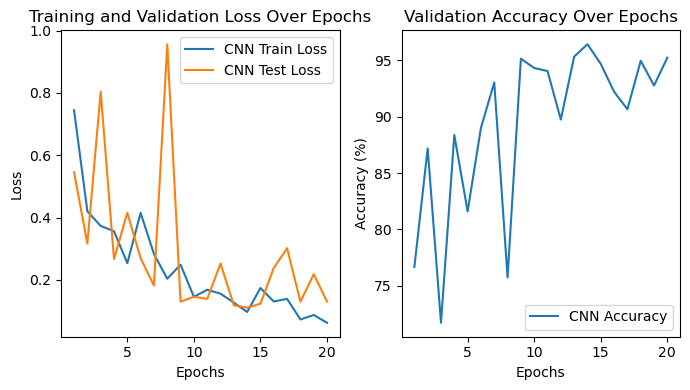

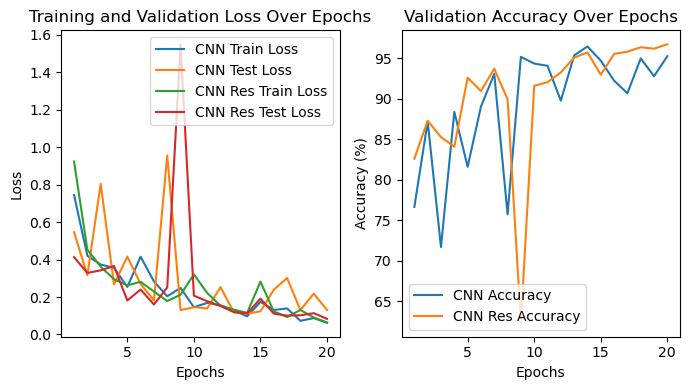

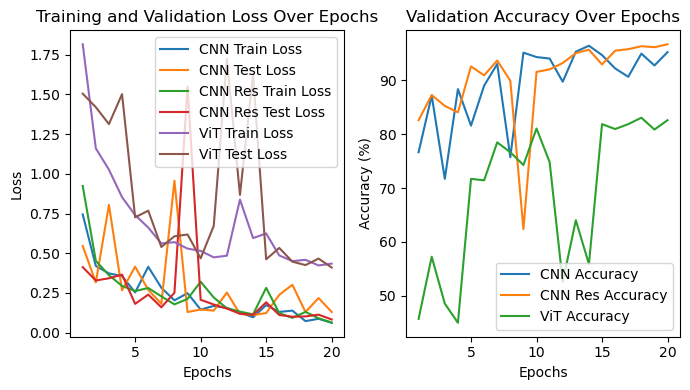

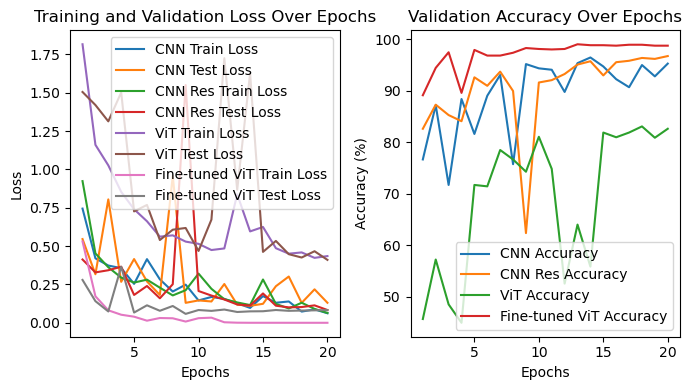

In [ ]:
import matplotlib.pyplot as plt

# Load the results
cnn_train_loss = np.load('results/cnn_train_loss_list.npy')
cnn_test_loss = np.load('results/cnn_test_loss_list.npy')
cnn_accuracy = np.load('results/cnn_accuracy_list.npy')

cnn_res_train_loss = np.load('results/cnn_res_train_loss_list.npy')
cnn_res_test_loss = np.load('results/cnn_res_test_loss_list.npy')
cnn_res_accuracy = np.load('results/cnn_res_accuracy_list.npy')

vit_train_loss = np.load('results/vit_train_loss_list.npy')
vit_test_loss = np.load('results/vit_test_loss_list.npy')
vit_accuracy = np.load('results/vit_accuracy_list.npy')

vit_ft_train_loss = np.load('results/vit_ft_train_loss_list.npy')
vit_ft_test_loss = np.load('results/vit_ft_test_loss_list.npy')
vit_ft_accuracy = np.load('results/vit_ft_accuracy_list.npy')

# Figure 1: Plot only CNN
fig1, (ax1_1, ax2_1) = plt.subplots(1, 2, figsize=(7, 4))  # Smaller figure size
plot_accuracy_results(cnn_train_loss, cnn_test_loss, cnn_accuracy, "CNN", ax1_1, ax2_1)
plt.tight_layout()
plt.show()

# Figure 2: Plot CNN and CNN with Residual Blocks
fig2, (ax1_2, ax2_2) = plt.subplots(1, 2, figsize=(7, 4))
plot_accuracy_results(cnn_train_loss, cnn_test_loss, cnn_accuracy, "CNN", ax1_2, ax2_2)
plot_accuracy_results(cnn_res_train_loss, cnn_res_test_loss, cnn_res_accuracy, "CNN Res", ax1_2, ax2_2)
plt.tight_layout()
plt.show()

# Figure 3: Plot CNN, CNN with Residual Blocks, and ViT
fig3, (ax1_3, ax2_3) = plt.subplots(1, 2, figsize=(7, 4))
plot_accuracy_results(cnn_train_loss, cnn_test_loss, cnn_accuracy, "CNN", ax1_3, ax2_3)
plot_accuracy_results(cnn_res_train_loss, cnn_res_test_loss, cnn_res_accuracy, "CNN Res", ax1_3, ax2_3)
plot_accuracy_results(vit_train_loss, vit_test_loss, vit_accuracy, "ViT", ax1_3, ax2_3)
plt.tight_layout()
plt.show()

# Figure 4: Plot CNN, CNN with Residual Blocks, ViT, and Fine-tuned ViT
fig4, (ax1_4, ax2_4) = plt.subplots(1, 2, figsize=(7, 4))
plot_accuracy_results(cnn_train_loss, cnn_test_loss, cnn_accuracy, "CNN", ax1_4, ax2_4)
plot_accuracy_results(cnn_res_train_loss, cnn_res_test_loss, cnn_res_accuracy, "CNN Res", ax1_4, ax2_4)
plot_accuracy_results(vit_train_loss, vit_test_loss, vit_accuracy, "ViT", ax1_4, ax2_4)
plot_accuracy_results(vit_ft_train_loss, vit_ft_test_loss, vit_ft_accuracy, "Fine-tuned ViT", ax1_4, ax2_4)
plt.tight_layout()
plt.show()


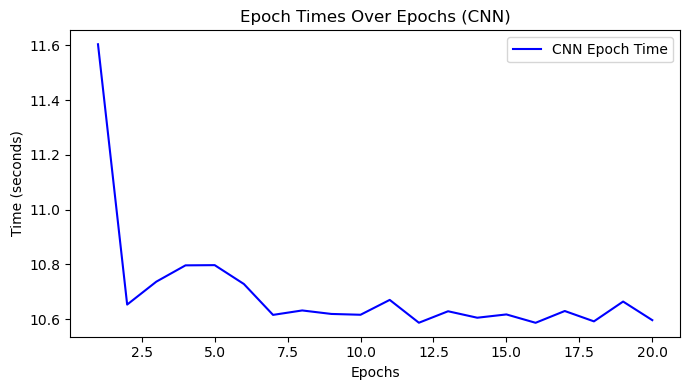

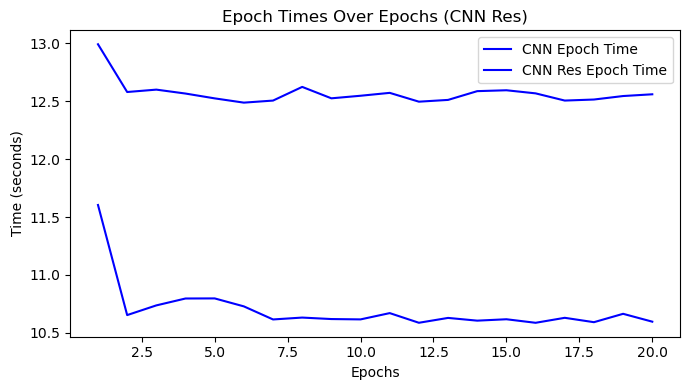

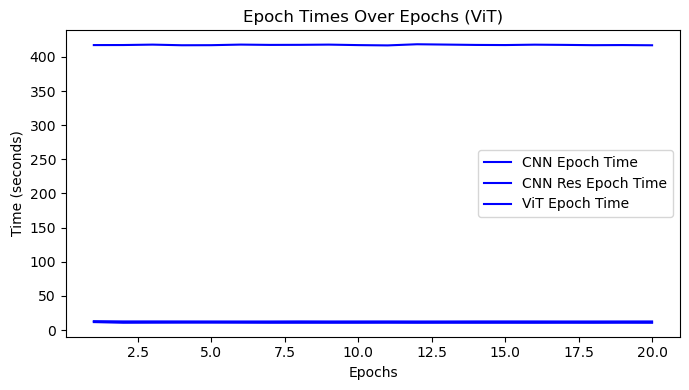

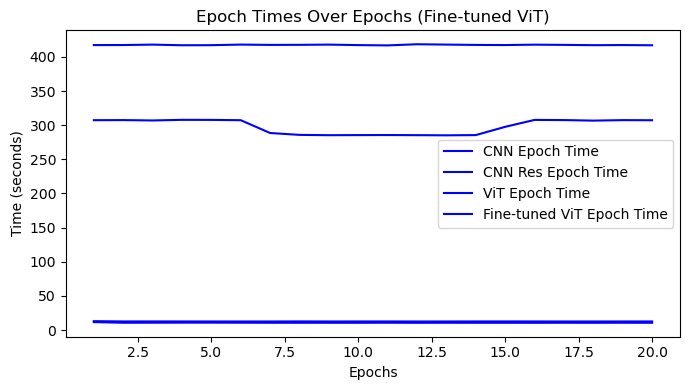

In [ ]:
# Load the epoch times for all models
cnn_epoch_times = np.load('results/cnn_epoch_times_list.npy')
cnn_res_epoch_times = np.load('results/cnn_res_epoch_times_list.npy')
vit_epoch_times = np.load('results/vit_epoch_times_list.npy')
vit_ft_epoch_times = np.load('results/vit_ft_epoch_times_list.npy')

# Figure 1: Plot only CNN epoch times
fig1, ax1 = plt.subplots(figsize=(7, 4))  # Smaller figure size
plot_epoch_times(cnn_epoch_times, "CNN", ax1)
plt.tight_layout()
plt.show()

# Figure 2: Plot CNN and CNN with Residual Blocks epoch times
fig2, ax2 = plt.subplots(figsize=(7, 4))
plot_epoch_times(cnn_epoch_times, "CNN", ax2)
plot_epoch_times(cnn_res_epoch_times, "CNN Res", ax2)
plt.tight_layout()
plt.show()

# Figure 3: Plot CNN, CNN with Residual Blocks, and ViT epoch times
fig3, ax3 = plt.subplots(figsize=(7, 4))
plot_epoch_times(cnn_epoch_times, "CNN", ax3)
plot_epoch_times(cnn_res_epoch_times, "CNN Res", ax3)
plot_epoch_times(vit_epoch_times, "ViT", ax3)
plt.tight_layout()
plt.show()

# Figure 4: Plot CNN, CNN with Residual Blocks, ViT, and Fine-tuned ViT epoch times
fig4, ax4 = plt.subplots(figsize=(7, 4))
plot_epoch_times(cnn_epoch_times, "CNN", ax4)
plot_epoch_times(cnn_res_epoch_times, "CNN Res", ax4)
plot_epoch_times(vit_epoch_times, "ViT", ax4)
plot_epoch_times(vit_ft_epoch_times, "Fine-tuned ViT", ax4)
plt.tight_layout()
plt.show()


In [ ]:
# If you want to download the results locally

import shutil
from google.colab import files

# Compress the 'results' folder into a zip file
shutil.make_archive('results', 'zip', 'results')

# Create a download link for the zip file
files.download('results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>